## Housekeeping
Let's first set up our environment. 

In [1]:
import importlib
import types
from eth2spec.config.config_util import prepare_config
from eth2spec.utils.ssz.ssz_impl import hash_tree_root

In [2]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir) + "/notebooks/thunderdome")
import beaconrunner as br

In [3]:
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

We would rather see fast simulations, so let's use epochs that only last 4 slots...

In [4]:
prepare_config(".", "fast.yaml") # 4 slots per epoch
br.reload_package(br)
from beaconrunner.specs import SLOTS_PER_EPOCH, SECONDS_PER_SLOT
print("SLOTS_PER_EPOCH: ", SLOTS_PER_EPOCH)

SLOTS_PER_EPOCH:  4


Let's import some of the beaconrunner logic

In [5]:
import beaconrunner.simulator as simulator
import beaconrunner.network as network
from beaconrunner.validators.RANDAOValidator import RANDAOValidator
from beaconrunner.validators.LazyValidator import LazyValidator

## How does the RANDAO game work?

In [6]:
num_validators = 16
validators = [LazyValidator(i) for i in range(num_validators)]

# Create a genesis state
genesis_state = br.simulator.get_genesis_state(validators, seed="let's play randao")
# Validators load the state
[v.load_state(genesis_state.copy()) for v in validators]
simulator.skip_genesis_block(validators) # nothing to propose at genesis, skip to slot 1!

For simplicity let's just assume a fully connected network, meaning that all validators are connected with each other.

In [7]:
set_a = network.NetworkSet(validators=list(range(10)))
net = network.Network(validators = validators, sets = list([set_a]))

In [8]:
print("Genesis time =", validators[0].store.genesis_time, "seconds")
print("Store time =", validators[0].store.time, "seconds")
print("Current slot =", validators[0].data.slot)

Genesis time = 1578182400 seconds
Store time = 1578182412 seconds
Current slot = 1


In [9]:
def get_current_epoch_proposers():
    return get_epoch_proposers(epochs_ahead=0)

def get_next_epoch_proposers():
    return get_epoch_proposers(epochs_ahead=1)

def get_epoch_proposers(epochs_ahead=0):
    validator = net.validators[0]
    current_slot = br.specs.get_current_slot(validator.store)

    current_head_root = validator.get_head()
    current_state = validator.store.block_states[current_head_root].copy()
    current_epoch = br.specs.get_current_epoch(current_state)
    start_slot = br.specs.compute_start_slot_at_epoch(current_epoch)
    start_state = current_state.copy() if start_slot == current_state.slot else \
        validator.store.block_states[br.specs.get_block_root(current_state, current_epoch)].copy()
    
    current_epoch_proposers = []
    
    for slot in range(epochs_ahead * SLOTS_PER_EPOCH + start_slot, start_slot + (epochs_ahead+1) * SLOTS_PER_EPOCH):
        if slot < start_state.slot:
            continue
        if start_state.slot < slot:
            br.specs.process_slots(start_state, slot)
        current_epoch_proposers.append(br.specs.get_beacon_proposer_index(start_state))
    return current_epoch_proposers

In [10]:
genesis_proposer_expectation = ""
for i in range(10):
    genesis_proposer_expectation += "Proposer indices for epoch {}: {} \n".format(i, get_epoch_proposers(epochs_ahead=i))
print(genesis_proposer_expectation)

Proposer indices for epoch 0: [5, 7, 15, 4] 
Proposer indices for epoch 1: [6, 0, 5, 9] 
Proposer indices for epoch 2: [15, 2, 15, 6] 
Proposer indices for epoch 3: [4, 12, 2, 12] 
Proposer indices for epoch 4: [2, 15, 14, 4] 
Proposer indices for epoch 5: [15, 2, 7, 9] 
Proposer indices for epoch 6: [1, 14, 2, 1] 
Proposer indices for epoch 7: [3, 11, 5, 12] 
Proposer indices for epoch 8: [12, 15, 9, 1] 
Proposer indices for epoch 9: [11, 14, 9, 3] 



We now have a schedule for who is expected to propose when. But hold on, what about the parameters `MIN_SEED_LOKOK_AHEAD=1` and `MAX_SEED_LOOKAHEAD=4`?!? Good catch! 

The `MAX_SEED_LOOKAHEAD` is actually the minimum delay on validator activations and exits; it basically means that validators strategically activating and exiting can only affect the seed 4 epochs into the future, leaving a space of 3 epochs within which proposers can mix-in unknown info to scramble the seed and hence make stake grinding via activating or exiting validators non-viable.

A random seed is used to select all the committees and proposers for an epoch. Every epoch, the beacon chain accumulates randomness from proposers via the RANDAO and stores it. The seed for the current epoch is based on the RANDAO output from the epoch `MIN_SEED_LOOKUP + 1` ago. With `MIN_SEED_LOOKAHEAD` set to one, the effect is that we can know the seed for the current epoch and the next epoch, but not beyond (since the next-but-one epoch depends on randomness from the current epoch that hasn't been accumulated yet).

Let's see if this is true, i.e. "Don't trust, but verify!"

### Simulations

Let's first create some observer functions that extract relevant data at each timestep for us

In [11]:
import numpy as np

def current_slot(params, step, sL, s, _input):
    return ("current_slot", s["network"].validators[0].data.slot)

def current_epoch(params, step, sL, s, _input):
    return ("current_epoch", s["network"].validators[0].data.current_epoch)

def get_epoch_proposers(epochs_ahead=0):
    validator = net.validators[0]
    current_slot = br.specs.get_current_slot(validator.store)

    current_head_root = validator.get_head()
    current_state = validator.store.block_states[current_head_root].copy()
    current_epoch = br.specs.get_current_epoch(current_state)
    start_slot = br.specs.compute_start_slot_at_epoch(current_epoch)
    start_state = current_state.copy() if start_slot == current_state.slot else \
        validator.store.block_states[br.specs.get_block_root(current_state, current_epoch)].copy()
    
    current_epoch_proposers = []
    
    for slot in range(epochs_ahead * SLOTS_PER_EPOCH + start_slot, start_slot + (epochs_ahead+1) * SLOTS_PER_EPOCH):
        if slot < start_state.slot:
            continue
        if start_state.slot < slot:
            br.specs.process_slots(start_state, slot)
        current_epoch_proposers.append(br.specs.get_beacon_proposer_index(start_state))
    return current_epoch_proposers

def get_epoch_proposers(validator, epochs_ahead=0):
    current_slot = br.specs.get_current_slot(validator.store)
    current_head_root = validator.get_head()
    current_state = validator.store.block_states[current_head_root].copy()
    current_epoch = br.specs.get_current_epoch(current_state)
    start_slot = br.specs.compute_start_slot_at_epoch(current_epoch)
    start_state = current_state.copy() if start_slot == current_state.slot else \
        validator.store.block_states[br.specs.get_block_root(current_state, current_epoch)].copy()
    
    epoch_proposers = []
    
    for slot in range(epochs_ahead * SLOTS_PER_EPOCH + start_slot, start_slot + (epochs_ahead+1) * SLOTS_PER_EPOCH):
        if slot < start_state.slot:
            continue
        if start_state.slot < slot:
            br.specs.process_slots(start_state, slot)
        epoch_proposers.append(br.specs.get_beacon_proposer_index(start_state))
    return epoch_proposers

def get_current_proposer_indices(params, step, sL, s, _input):
    current_epoch_proposers = get_epoch_proposers(validator=s["network"].validators[0], epochs_ahead=0)
    return ("current_epoch_proposer_indices", current_epoch_proposers)

def get_next_proposer_indices(params, step, sL, s, _input):
    next_epoch_proposers = get_epoch_proposers(validator=s["network"].validators[0], epochs_ahead=1)
    return ("next_epoch_proposer_indices", next_epoch_proposers)

def balances(params, step, sL, s, _input):
    validators = s["network"].validators
    validator = validators[0]
    head = br.specs.get_head(validator.store)
    current_state = validator.store.block_states[head]
    current_epoch = br.specs.get_current_epoch(current_state)
    indices = [i for i, v in enumerate(validators)]
    balances = [b for i, b in enumerate(current_state.balances)]
    return ("balances", [np.round(br.utils.eth2.gwei_to_eth(balance), 6) for balance in balances])

observers = {
    "current_epoch": current_epoch,
    "current_slot": current_slot,
    "current_epoch_proposer_indices": get_current_proposer_indices,
    "next_epoch_proposer_indices": get_next_proposer_indices,
    "balances": balances,
}

In [12]:
from random import sample
from beaconrunner.validators.LazyValidator import LazyValidator

def simulate_once(network_sets, num_run, num_validators, network_update_rate, scenario="honest"):
    # Generate validators
    validators = [RANDAOValidator(i) for i in range(num_validators)]
    
    # Create a genesis state
    genesis_state = br.simulator.get_genesis_state(validators, seed="let's play randao")
    
    # Validators load the state
    [v.load_state(genesis_state.copy()) for v in validators]

    br.simulator.skip_genesis_block(validators) # forward time by SECONDS_PER_SLOT

    network = br.network.Network(validators = validators, sets=network_sets)

    parameters = br.simulator.SimulationParameters({
        "num_epochs": 3,
        "num_run": num_run,
        "frequency": 1,
        "network_update_rate": network_update_rate,
        "scenario": scenario,
    })

    return br.simulator.simulate(network, parameters, observers)

In [13]:
import pandas as pd
import numpy as np

num_validators = 16

# Create the network peers
set_a = br.network.NetworkSet(validators=list(range(num_validators)))
network_sets = list([set_a])

num_runs = 1
network_update_rate = 1

scenarios = ["honest", "skip", "slashable"]
scenario = scenarios[2]

single_scenario = True

if single_scenario:
    # comment/un-comment for simulating single scenario. Specify scenario above!
    df = pd.concat([simulate_once(network_sets, num_run, num_validators, network_update_rate, scenario) for num_run in range(num_runs)])
    df.insert(0, "scenario", scenario)
else:
    # df = pd.concat([simulate_once(network_sets, num_run, num_validators, network_update_rate, scenarios[i]) for i in range(len(scenarios)) for num_run in range(num_runs)])
    df = pd.DataFrame()
    for num_run in range(num_runs):
        for i in range(len(scenarios)):
            temp_df = simulate_once(network_sets, num_run, num_validators, network_update_rate, scenarios[i])
            temp_df.insert(0, "scenario", scenarios[i])
            df = pd.concat([df, temp_df])

Initializing configurations: 100%|██████████| 1/1 [00:00<00:00, 151.47it/s]

Scenario  Slashable : simulating 3 epochs ( 12 slots ) at frequency 1 moves/second
total 144 simulation steps

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (144, 3, 1, 6)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
7 proposing block for slot 1


15 proposing slashable blocks for slot 2
4 proposing block for slot 3
   --  4  detected a slashable incident in slot  2  by validator  15
6 proposing block for slot 4
0 proposing block for slot 5
5 proposing slashable blocks for slot 6
9 proposing block for slot 7
   --  9  detected a slashable incident in slot  6  by validator  5
14 proposing block for slot 8
2 proposing block for slot 9
timestep 100 of run 1
12 proposing slashable blocks for slot 10
* 5 slashed already; is shutting up!
* 5 slashed already; is shutting up!
11 proposing block for slot 12
   --  11  detected a slashable incident in slot  10  by validator  12


Flattening results:   0%|          | 1/433 [00:00<00:01, 239.69it/s]

Total execution time: 30.77s


In [14]:
pd.set_option('max_colwidth', 300)
df[3::3*12][["scenario", "current_epoch", "current_slot", "current_epoch_proposer_indices", "next_epoch_proposer_indices", "balances"]]

,scenario,current_epoch,current_slot,current_epoch_proposer_indices,next_epoch_proposer_indices,balances
3,slashable,0,1,"[5, 7, 15, 4]","[6, 0, 5, 9]","[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0]"
39,slashable,0,2,"[5, 7, 15, 4]","[6, 0, 5, 9]","[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0]"
75,slashable,0,3,"[5, 7, 15, 4]","[6, 0, 5, 9]","[32.0, 32.0, 32.0, 32.0, 32.0625, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 31.0]"
111,slashable,1,4,"[6, 0, 5, 9]","[14, 2, 12, 5]","[32.0, 32.0, 32.0, 32.0, 32.0625, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 31.0]"
147,slashable,1,5,"[6, 0, 5, 9]","[14, 2, 12, 5]","[32.0, 32.0, 32.0, 32.0, 32.0625, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 31.0]"
183,slashable,1,6,"[6, 0, 5, 9]","[14, 2, 12, 5]","[32.0, 32.0, 32.0, 32.0, 32.0625, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 31.0]"
219,slashable,1,7,"[6, 0, 5, 9]","[14, 2, 12, 5]","[32.0, 32.0, 32.0, 32.0, 32.0625, 31.0, 32.0, 32.0, 32.0, 32.0625, 32.0, 32.0, 32.0, 32.0, 32.0, 31.0]"
255,slashable,2,8,"[14, 2, 12, 5]","[11, 1, 5, 7]","[32.002107, 32.002107, 31.997851, 32.002107, 32.064965, 30.997851, 32.002375, 31.997851, 32.002107, 32.064607, 31.997851, 32.002107, 32.002107, 32.002107, 32.002107, 30.998277]"
291,slashable,2,9,"[14, 2, 12, 5]","[11, 1, 5, 7]","[32.002107, 32.002107, 31.997851, 32.002107, 32.064965, 30.997851, 32.002375, 31.997851, 32.002107, 32.064607, 31.997851, 32.002107, 32.002107, 32.002107, 32.002107, 30.998277]"
327,slashable,2,10,"[14, 2, 12, 5]","[11, 1, 5, 7]","[32.002107, 32.002107, 31.997851, 32.002107, 32.064965, 30.997851, 32.002375, 31.997851, 32.002107, 32.064607, 31.997851, 32.002107, 32.002107, 32.002107, 32.002107, 30.998277]"


### Experiment A
In slot 31 let the proposer skip her duties, then forward state to slot 0 of epoch 1, record the proposer.

We are using "fast" specs (`SLOTS_PER_EPOCH = 4`). So skip block proposal for slot `3`, otherwise proceed as usual

### Experiment B
In slot 31 of epoch 0, a block was proposed for slot 31, then forward the state to slot 0 of epoch 1, record the proposer.

We are using "fast" specs (`SLOTS_PER_EPOCH = 4`). So propose a block in slot `3` as per usual and then forward state to next epoch. 

Are the proposers different between experiment A and B?

### Experiment C

The block at slot 31 of epoch 0 has a slashing event. Forward the state to slot 0 of epoch 1. Is it still the same proposer?

We are using "fast" specs (`SLOTS_PER_EPOCH = 4`). Create a slashable event for block proposer of slot `3`. Then forward state to next epoch and record proposers. 

Can we confirm the intuition that the proposer in experiment C is different than in experiment A&B?

## Plotting the block tree

Let's visualize how the blockchain evolved

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz
from networkx.drawing.nx_agraph import pygraphviz_layout

In [16]:
# Just grab any Network() of any validator from the typical beaconrruner df output: 
# This allows us to access the validator'S store and recover block tree from it 
network = df["network"].iloc[0]

blocks_dict = network.validators[0].store.blocks # access blocks from validator's Store

block_headers = list(blocks_dict.values()) # extract block headers
block_roots = list(blocks_dict) # extract block roots

tree = nx.DiGraph()

# Add all blocks as nodes to directed graph
for index, block_header in enumerate(block_headers):
    tree.add_nodes_from([
    (index, {"slot": block_header.slot, "parent_root": block_header.parent_root, "block_root": block_roots[index]})
    ])

# Add edges between blocks respectively
for i in range(len(tree)):
    for j in range(len(tree)):
        if tree.nodes()[i]["parent_root"] == tree.nodes()[j]["block_root"]:
            tree.add_edge(i, j)

In [17]:
# latest_block_root = network.validators[0].get_head()
# last_block_index = [x for x,y in tree.nodes(data=True) if y['block_root']==latest_block_root][0]

def get_node_index(block_root):
    return [x for x,y in tree.nodes(data=True) if y['block_root']==block_root][0]

def get_parent_node_index(block_index):
    parent_block_root = block_headers[block_index].parent_root
    parent_node_index = get_node_index(parent_block_root)
    return parent_node_index

def tag_chain(network):
    latest_block_root = network.validators[0].get_head()
    last_block_index = [x for x,y in tree.nodes(data=True) if y['block_root']==latest_block_root][0]

    canonical_chain = [last_block_index]
    query_next = last_block_index
    while True:
        parent = get_parent_node_index(query_next)
        canonical_chain.insert(0, parent)
        if parent == 0: #genesis
            break
        query_next = parent

    orphaned_chain = list(set(list(range(canonical_chain[-1]+1))) - set(canonical_chain))

    return canonical_chain, orphaned_chain

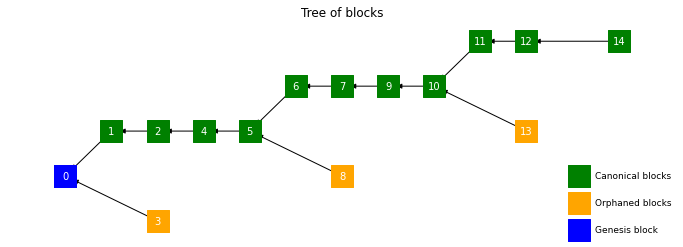

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4), sharex=True, sharey=True)

pos = pygraphviz_layout(tree, prog='dot', args='-Grankdir="RL"')
for i in pos:
    pos[i] = (block_headers[i].slot + 200, pos[i][1])

plt.title("Tree of blocks")

canonical_chain_ids, orphaned_chain_ids = tag_chain(network)

nx.draw_networkx_nodes(tree,pos=pos, nodelist=canonical_chain_ids, node_color='green', label="Canonical blocks", node_shape='s', node_size=500)
nx.draw_networkx_nodes(tree,pos=pos, nodelist=orphaned_chain_ids, node_color='orange', label="Orphaned blocks", node_shape='s', node_size=500)
nx.draw_networkx_nodes(tree,pos=pos, nodelist=[0], node_color='blue', label="Genesis block", node_shape='s', node_size=500)    

nx.draw_networkx_edges(tree, pos, arrows=True)
nx.draw_networkx_labels(tree, pos, font_size=10, font_color="white")

ax.set_frame_on(False)
plt.legend(loc="lower right", labelspacing=2, fontsize=9, frameon=False, borderpad=0.1)

# plt.legend(labelspacing=0.8, fontsize=9, frameon=False, borderpad=0.1)
plt.show()